In [100]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import matplotlib.pyplot as plt

from monte_carlo import wolff_algorithm
from xy_model import XYModel2DWolff

seed = 1
grid_size = 5
temp = 0.1

def set_seed(seed):
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(seed)
xy = XYModel2DWolff(grid_size)
logger = wolff_algorithm(xy, temp, 1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8323933376968093


In [103]:
def show_spin(xy_model: XYModel2DWolff):
    x, y = np.meshgrid(np.arange(xy_model.grid_size), np.arange(xy_model.grid_size))
    spin = xy_model.get_spin()

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(3, 3)
    ax.quiver(x, y, spin.cos(), spin.sin())
    ax.set_aspect(1)

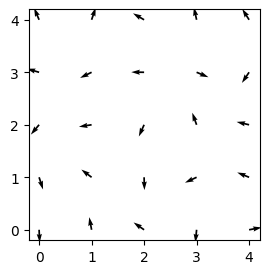

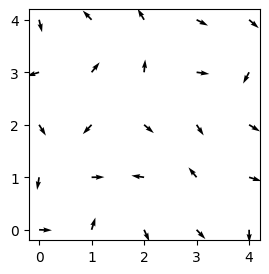

In [104]:
set_seed(seed)
xy_model = XYModel2DWolff(grid_size)
show_spin(xy_model)

for _ in range(1000):
    # randomly choose a Wolff plane        
    nW = 2 * torch.pi * torch.rand((1, )).item()
    # print(nW)
    # update bond according to the Wolff plane
    xy_model.update_bond(nW=nW, beta=1 / temp)

    # select one cluster according to the bond
    flip_cluster = xy_model.flip_one_cluster(nW=nW, debug=True)
    # print(flip_cluster)

show_spin(xy_model)